In [1]:
import random

# Constants
MAX_LINES = 3
MAX_BET = 100
MIN_BET = 1

ROWS = 3
COLS = 3

# Symbol definitions with probabilities and values
symbols = {
    "A": {"count": 1, "value": 20},
    "B": {"count": 3, "value": 15},
    "C": {"count": 5, "value": 10},
    "D": {"count": 7, "value": 8},
    "E": {"count": 9, "value": 5}
}

# Multiplier definitions
multipliers = {
    "A": 3,
    "B": 2.5,
    "C": 2,
    "D": 1.5,
    "E": 1.2
}

def check_winnings(columns, lines, bet, values, multipliers):
    winnings = 0
    winning_lines = []
    for line in range(lines):
        symbol = columns[0][line]
        for column in columns:
            symbol_to_check = column[line]
            if symbol != symbol_to_check:
                break
        else:
            winnings += values[symbol] * bet * multipliers[symbol]
            winning_lines.append(line + 1)
    return winnings, winning_lines

def get_slot_machine_spin(rows, cols, symbols):
    all_symbols = []
    for symbol, symbol_info in symbols.items():
        for _ in range(symbol_info["count"]):
            all_symbols.append(symbol)

    columns = []
    for _ in range(cols):
        column = []
        current_symbols = all_symbols[:]
        for _ in range(rows):
            value = random.choice(current_symbols)
            current_symbols.remove(value)
            column.append(value)
        columns.append(column)

    return columns

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Parameters for DQN
num_spins_dqn = 10000
initial_balance_dqn = 1000
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
alpha = 0.001  # Learning rate
gamma = 0.9  # Discount factor
batch_size = 64
memory_size = 10000

# Define the state and action space
state_space = 4  # balance, bet, win_streak, loss_streak
action_space = 3  # cautious, aggressive, random

# Neural network model
class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_space, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_space)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize DQN, loss function, and optimizer
model = DQN(state_space, action_space)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=alpha)

# Experience replay memory
memory = deque(maxlen=memory_size)

def get_state(balance, bet, win_streak, loss_streak):
    return np.array([balance, bet, win_streak, loss_streak])

def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return random.choice([0, 1, 2])
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return model(state).argmax().item()

def update_memory(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def replay():
    if len(memory) < batch_size:
        return
    
    mini_batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*mini_batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = model(states).gather(1, actions).squeeze()
    next_q_values = model(next_states).max(1)[0]
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = criterion(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def simulate_dqn_player(start_balance, num_spins):
    balance = start_balance
    balances = []
    win_streak = 0
    loss_streak = 0
    epsilon = epsilon_start
    for i in range(num_spins):
        balances.append(balance)
        state = get_state(balance, max(MIN_BET, min(int(balance * 0.01), MAX_BET)), win_streak, loss_streak)
        action = choose_action(state, epsilon)
        
        if action == 0:
            bet = max(MIN_BET, min(int(balance * 0.01), MAX_BET))
        elif action == 1:
            bet = min(int(balance * 0.02), MAX_BET)
        else:
            bet = max(MIN_BET, min(int(balance * random.uniform(0.01, 0.1)), MAX_BET))
        
        lines = random.randint(1, MAX_LINES)
        total_bet = bet * lines
        if total_bet > balance:
            continue

        slots = get_slot_machine_spin(ROWS, COLS, symbols)
        winnings, _ = check_winnings(slots, lines, bet, {k: v["value"] for k, v in symbols.items()}, multipliers)
        next_balance = balance + winnings - total_bet
        reward = next_balance - balance
        next_state = get_state(next_balance, bet, win_streak if winnings > 0 else 0, loss_streak + 1 if winnings == 0 else 0)
        done = next_balance <= 0
        
        update_memory(state, action, reward, next_state, done)
        replay()
        
        balance = next_balance
        if winnings > 0:
            win_streak += 1
            loss_streak = 0
        else:
            loss_streak += 1
            win_streak = 0
        
        if done:
            break
        
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

    return balances

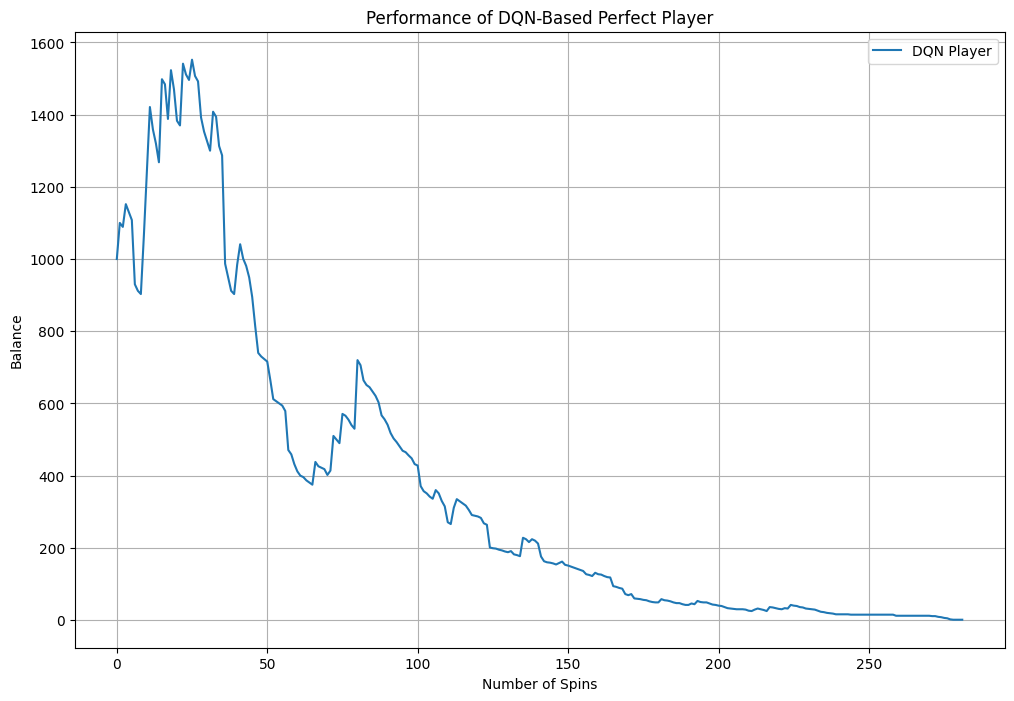

In [4]:
# Simulate the DQN-based perfect player
balances_dqn_player = simulate_dqn_player(initial_balance_dqn, num_spins_dqn)

import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(len(balances_dqn_player)), balances_dqn_player, label='DQN Player')
plt.xlabel('Number of Spins')
plt.ylabel('Balance')
plt.title('Performance of DQN-Based Perfect Player')
plt.legend()
plt.grid(True)
plt.show()
